# X_RAY 사진 기반 코로나 감염 예측 데이터 분석

우선 데이터는 데이터 이름, 데이터 사진과 판단, 수집기관이 적혀있는 txt파일과 각 X_RAY 이미지 파일로 구성되어 있다.

데이터가 12GB나 되서 캐글 데이터 셋 링크로 대체

https://www.kaggle.com/andyczhao/covidx-cxr2

### 1. 먼저 데이터에 대한 정보가 들어있는 파일을 열어보자

txt파일로 저장되어 있어서 read_csv의 sep와 engine을 조절하고 파일에 header가 없기 때문에 가장 첫 줄이 index가 되는 것을 방지하기 위해 header = None를 사용

In [1]:
import pandas as pd
train = pd.read_csv('./COVID_XRAY/train.txt',sep = " ", engine='python',header=None)
test = pd.read_csv('./COVID_XRAY/test.txt',sep = " ", engine='python',header= None)
train_path = './COVID_XRAY/train/'
test_path = './COVID_XRAY/test/'

각 파일별 이름과 라벨을 구분

In [2]:
train.head()

,0,1,2,3
0,5,ARDSSevere.png,negative,cohen
1,25,acute-respiratory-distress-syndrome-ards-1.jpg,negative,cohen
2,26,acute-respiratory-distress-syndrome-ards.jpg,negative,cohen
3,27,ards-secondary-to-tiger-snake-bite.png,negative,cohen
4,28,pneumocystis-pneumonia-2-PA.png,negative,cohen


In [3]:
test.head()

,0,1,2,3
0,419639-003251,MIDRC-RICORD-1C-419639-003251-46647-0.png,positive,ricord
1,419639-001464,MIDRC-RICORD-1C-419639-001464-39871-0.png,positive,ricord
2,419639-000918,MIDRC-RICORD-1C-419639-000918-78965-0.png,positive,ricord
3,419639-003318,MIDRC-RICORD-1C-419639-003318-64285-0.png,positive,ricord
4,419639-001015,MIDRC-RICORD-1C-419639-001015-81591-0.png,positive,ricord


**데이터 shuffle(with df.sample)**

In [4]:
train = train.sample(frac=1, replace=True, random_state=123)
test = test.sample(frac=1, replace=True, random_state=123)

In [5]:
train.head()

,0,1,2,3
3582,3ffd6f8f-a701-46b4-8720-806cb7332718,3ffd6f8f-a701-46b4-8720-806cb7332718.png,negative,rsna
15725,1462ffd1-939b-49b7-9234-eeeb7f4986cc,1462ffd1-939b-49b7-9234-eeeb7f4986cc.png,negative,rsna
11646,3ddfe89f-2b00-49cc-ad50-30ac45c8aad2,3ddfe89f-2b00-49cc-ad50-30ac45c8aad2.png,negative,rsna
1346,COVID_641,COVID(641).png,positive,sirm
12252,65b87566-709e-4b0f-b4bb-55020515f6e7,65b87566-709e-4b0f-b4bb-55020515f6e7.png,negative,rsna


In [6]:
test.head()

,0,1,2,3
365,8ae822ae-a656-47ba-ac5b-848ce2256575,8ae822ae-a656-47ba-ac5b-848ce2256575.png,negative,rsna
382,a6236ddd-6367-4569-b5f1-07d2df9390ad,a6236ddd-6367-4569-b5f1-07d2df9390ad.png,negative,rsna
322,e1d5a233-39ca-41dc-a289-b07c3e78cdb1,e1d5a233-39ca-41dc-a289-b07c3e78cdb1.png,negative,rsna
98,419639-003060,MIDRC-RICORD-1C-419639-003060-04928-0.png,positive,ricord
230,d3ad2915-af30-426c-ad2d-1634df8c1b5f,d3ad2915-af30-426c-ad2d-1634df8c1b5f.png,negative,rsna


**데이터의 구성**을 분석해 보면

\[patient id\] \[filename\] \[class\] \[data source\]  from kaggle

0. name(number? data id?)(파일이름에서 확장자가 빠진경우가 많음 -> 대략 데이터 ID정도로 생각됨)
1. file name(파일 이름)
2. covid decision(positive vs negative)(판정)
3. Academy(학회)

우리는 여기에서 1,2만 사용한다!

1은 파일 호출용 2는 예측 결과용

In [7]:
train_name = train.iloc[:,1]
train_label = train.iloc[:,2]
test_name = test.iloc[:,1]
test_label = test.iloc[:,2]

이미지 읽어들이기 연습 cv2 모듈을 사용.

In [8]:
!pip install memory_profiler

You should consider upgrading via the 'c:\users\ad\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


데이터가 상당히 크니까 메모리 사용량을 추적해야 한다.

In [9]:
%load_ext memory_profiler
%memit

peak memory: 88.00 MiB, increment: 0.07 MiB


train데이터는 15951개 개당 500,500으로 줄여서 부르면 개당 0.7MB

-> 1000개를 부르면 820.29MB -> 87.74 => 차이는 732.55 => 개당 0.73255MB

In [10]:
print(len(train_name))

15951


In [11]:
print(len(test_name))

400


Resize
~~~
import cv2
data = cv2.imread(train_path+train_name[15],cv2.IMREAD_COLOR)
cv2.imshow('Original', data)
data = cv2.resize(data, (500,500), interpolation = cv2.INTER_AREA)
data_r = data[:,:,0]
data_g = data[:,:,1]
data_b = data[:,:,2]
cv2.imshow('r_channel', data_r)
cv2.imshow('g_channel', data_g)
cv2.imshow('b_channel', data_b)
cv2.waitKey(0)
cv2.destroyAllWindows()
~~~

In [13]:
import cv2
import time

# 데이터 shuffle을 하고 1000개씩 묶어서 학습진행 해보자.
image = []
batch_size = 1000
block = 1

start = time.time()
for i, name in enumerate(train_name):
    if i > batch_size * block:
        break;
    fname = train_path + name
    data = cv2.imread(fname,cv2.IMREAD_COLOR)
    data = cv2.resize(data, (500,500), interpolation = cv2.INTER_AREA)
    image.append(data)
#     %memit
%memit

print('Time Eleapsed: {0:.4}ms'.format(time.time()-start))
# cv2.imshow('Original', original)
# cv2.imshow('Gray', gray)
# cv2.imshow('Unchange', unchange)

# cv2.waitKey(0)
# cv2.destroyAllWindows()

peak memory: 813.52 MiB, increment: 0.00 MiB
Time Eleapsed: 20.27ms


데이터의 편향성이 보인다 -> __13793 음성 vs 2158 양성__

In [14]:
train[2].value_counts()

negative    13759
positive     2192
Name: 2, dtype: int64

In [15]:
test[2].value_counts()

negative    202
positive    198
Name: 2, dtype: int64

데이터 크기가 제각각이다. 크기를 다룰 필요가 있다.

In [16]:
data = cv2.resize(data, (500,500), interpolation = cv2.INTER_AREA)

image들을 list에 넣어서 이를 ndarray로 바꾸려고 시도를 했으나 dimention이 32가 최대라는 에러를 퉤 뱉어냄

=> 이는 그냥 리스트에 넣은 것을 호출해서 사용하는 것으로 해결해야하나..?

SOLVED: np.ndarray가 아니라 np.array를 호출해야 한다.

In [17]:
import numpy as np
dataset_block = np.array(image)
print(dataset_block.shape)
image = []

(1001, 500, 500, 3)


데이터는 __너비x높이x채널__로 구성되어 있다.

데이터 중 하나를 예시로 보자

In [18]:
data_r = data[:,:,0]
data_g = data[:,:,1]
data_b = data[:,:,2]

In [19]:
cv2.imshow('r_channel', data_r)
cv2.imshow('g_channel', data_g)
cv2.imshow('b_channel', data_b)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
height,width, channel = data.shape
print(height,width, channel)

500 500 3


**데이터 하나에 500x500의 픽셀데이터가 있는데 이 값들은 0 ~ 255의 값 이므로 255로 나눠서 0~1사이의 값으로 정규화를 진행해보자.**

### 중간 점검
1. 먼저 __데이터의 개수__는 
- train은 15951 그 중 양성: 2158 음성: 13793
- test는 400 그 중 양성 198 음성: 202
2. __사진 데이터의 크기__는 제각각 -> 이는 500 x 500의 BGR 3채널 데이터로 resize를 진행한다.
3. __사진 데이터 1개를 resize__해서 메모리에 올리면 대략 0.73MB가 증가 -> 1000개를 불러서 array에 저장했을 때 732.55MB
4. __학습 컨테이너를 만들자.__ 학습 컨테이너에서 데이터를 읽어서 저장(block_size) -> 학습 함수 호출 -> 반복
5. __학습 함수__를 만들어서 parameter로 각종 정보를 가지는 dict 자료형을 사용해보자
6. __학습 함수__에는 모델, batch_size(한번에 학습시킬 데이터 수), 학습 데이터를 받아서 사용
- 여기에서 sci-kit learn의 train_test_split을 사용해보자!
- split하고 train은 기존 데이터를 사용하고 test데이터를 validation 데이터로 사용
- ex) 1000개 중 200개를 validation 데이터로 사용하되 학습은 1000개 모두 사용.

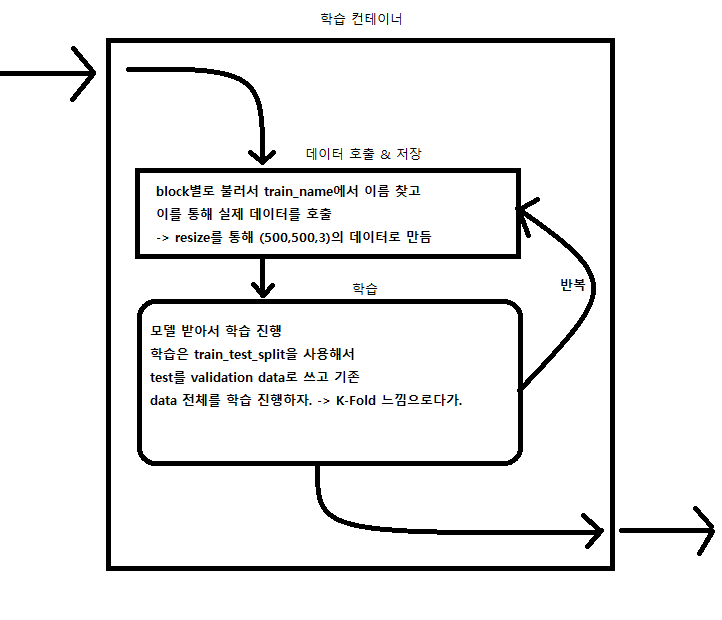

```%memit``` 로 계속 메모리 체크해줘야 함.